In [7]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## Simulate Buying and Selling Stock Using ARMA(p,q)

In [36]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1
        
        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        #for idx, event in enumerate(events_list):
           # plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
           # if event[0] == 's':
              #  color = 'green' if event[2] > 0 else 'red'
                #plt.fill_betweenx(range(*shaded_y_lims), 
                                 # event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

## Read the data


In [9]:
tickerSymbol = 'PG'
data = yf.Ticker(tickerSymbol)
data

yfinance.Ticker object <PG>

In [27]:
prices = data.history(start='2019-01-01', end='2023-04-01').Close
returns = prices.pct_change().dropna()
returns

Date
2019-01-03 00:00:00-05:00   -0.007011
2019-01-04 00:00:00-05:00    0.020410
2019-01-07 00:00:00-05:00   -0.004000
2019-01-08 00:00:00-05:00    0.003691
2019-01-09 00:00:00-05:00   -0.016331
                               ...   
2023-03-27 00:00:00-04:00   -0.005248
2023-03-28 00:00:00-04:00    0.002809
2023-03-29 00:00:00-04:00    0.003075
2023-03-30 00:00:00-04:00    0.004359
2023-03-31 00:00:00-04:00    0.008410
Name: Close, Length: 1069, dtype: float64

Text(0.5, 1.0, 'Stock prices from Jan 2023 to April 2023')

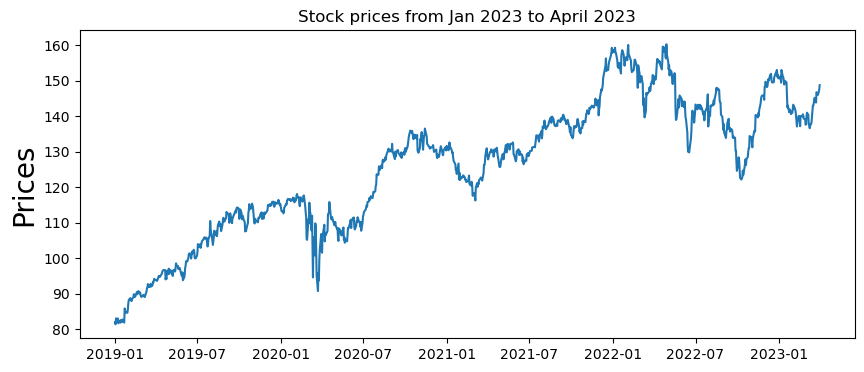

In [28]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)
plt.title("Stock prices from Jan 2023 to April 2023")

Text(0.5, 1.0, 'Plot of the returns')

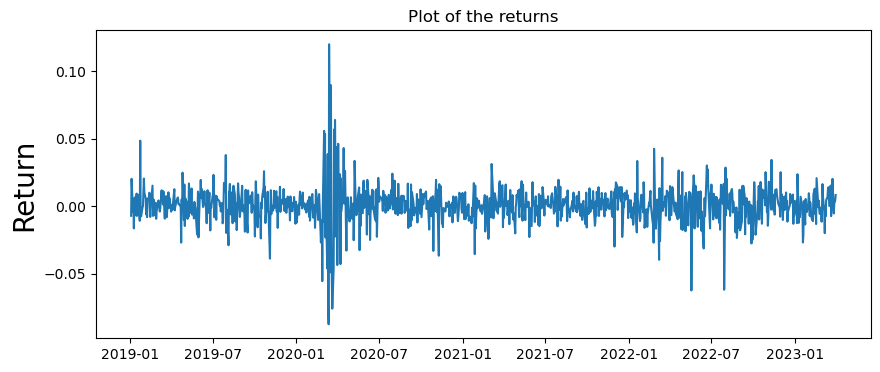

In [29]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)
plt.title("Plot of the returns")

In [30]:
##stationarity test
from statsmodels.tsa.stattools import adfuller


def ad_test(dataset):
    dftest = adfuller(dataset, autolag= 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. p-value : ", dftest[1])
    print("3. num of logs : ", dftest[2])
    print("4. num of obs used for adf regression and Cr.V : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)

In [31]:
ad_test(prices) ##smaller the p value it means its stationary

1. ADF :  -2.1041468740455542
2. p-value :  0.24285039547363207
3. num of logs :  9
4. num of obs used for adf regression and Cr.V :  1060
5. Critical Values : 
	 1% : -3.4365341571171166
	 5% : -2.8642704999764907
	 10% : -2.568223820754717


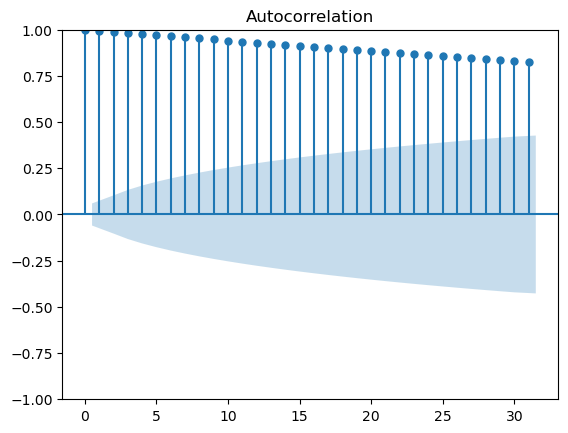

In [32]:
plot_acf(prices)
plt.show()

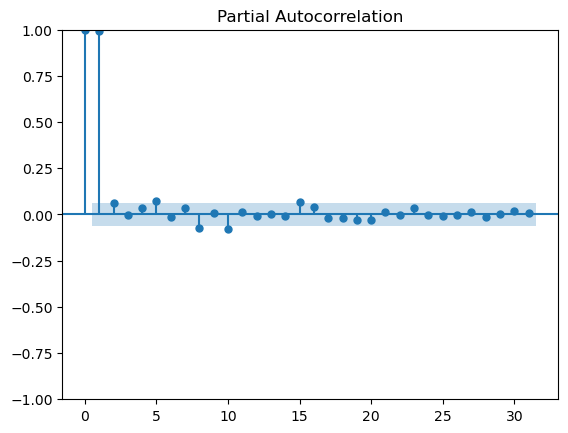

In [33]:
plot_pacf(prices)
plt.show()

In [17]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [18]:
model = auto_arima(prices, trace= True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8154.819, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8175.391, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8156.649, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8156.977, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8176.025, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8155.612, Time=1.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8160.143, Time=2.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8120.623, Time=4.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8143.882, Time=1.43 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=8114.503, Time=2.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=8130.955, Time=1.50 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=8116.189, Time=3.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=8110.849, Time=8.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8120.065, Time=5.90 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept

In [19]:
##testing the model 
from statsmodels.tsa.arima.model import ARIMA


In [20]:
print(prices.shape)
train = prices.iloc[:-1170]
test = prices.iloc[-1170:]
print(train.shape, test.shape)

(2580,)
(1410,) (1170,)


In [21]:
#train the model 


In [22]:
modell = ARIMA(train, order= (4,1,4))
modell = modell.fit()
modell.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1410
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -1256.122
Date:                Sun, 16 Apr 2023   AIC                           2530.244
Time:                        21:21:04   BIC                           2577.500
Sample:                             0   HQIC                          2547.904
                               - 1410                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4237      0.069     -6.108      0.000      -0.560      -0.288
ar.L2          0.7368      0.044     16.847      0.000       0.651       0.823
ar.L3         -0.4990      0.033    -15.173      0.000      -0.563      -0.435
ar.L4         -0.9135      0.064    -14.363      0.000      -1.038      -0.789
ma.L1          0.4201      0.071      5.895      0.000       0.280       0.560
ma.L2         -0.7624      0.044    -17.304      0.000      -0.849      -0.676
ma.L3          0.5009      0.033     14.982      0.000       0.435       0.566
ma.L4          0.9187      0.066     13.895      0.000       0.789       1.048
sigma2         0.3479      0.008     42.712      0.000       0.332       0.364
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):               769.53
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
## prediction on test set 

In [24]:
start = len(train)
end = len(train) + len(test)-1
pred= modell.predict(start=start, end=end, typ='levels')
print(pred)
pred.index= prices.index[start:end+1]
print(pred)

1410    73.490808
1411    73.501745
1412    73.391200
1413    73.381983
1414    73.351600
          ...    
2575    73.440097
2576    73.440088
2577    73.440083
2578    73.440083
2579    73.440089
Name: predicted_mean, Length: 1170, dtype: float64
Date
2018-08-08 00:00:00-04:00    73.490808
2018-08-09 00:00:00-04:00    73.501745
2018-08-10 00:00:00-04:00    73.391200
2018-08-13 00:00:00-04:00    73.381983
2018-08-14 00:00:00-04:00    73.351600
                               ...    
2023-03-27 00:00:00-04:00    73.440097
2023-03-28 00:00:00-04:00    73.440088
2023-03-29 00:00:00-04:00    73.440083
2023-03-30 00:00:00-04:00    73.440083
2023-03-31 00:00:00-04:00    73.440089
Name: predicted_mean, Length: 1170, dtype: float64


<AxesSubplot:xlabel='Date'>

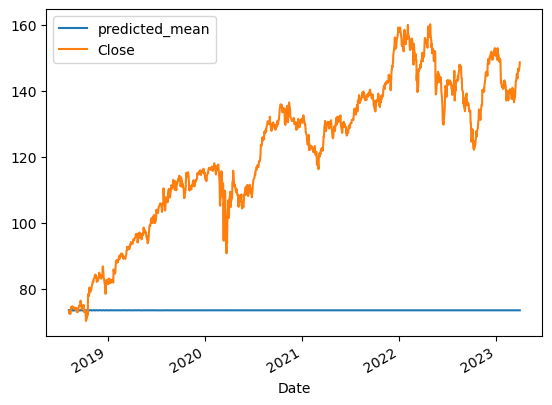

In [25]:
pred.plot(legend=True)
test.plot(legend=True)

## Model 

100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 2717.99it/s]


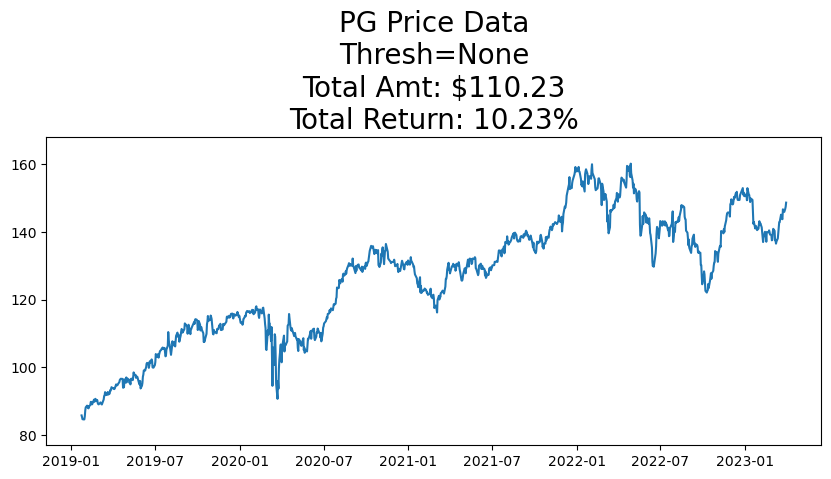

110.23084384827564

In [37]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

#### creating a loop for the model 

In [38]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 2355.71it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 2669.24it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 2718.26it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 3992.75it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 1395.00it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 6703.73it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 6900.06it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 6738.55it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 6052.96it/s]


100%|█████████████████████████████████████| 1055/1055 [00:00<00:00, 7161.48it/s]


Text(0.5, 1.0, 'Plot of 1000 simulation of returns \nAvg: $123.28\nSD: $28.31')

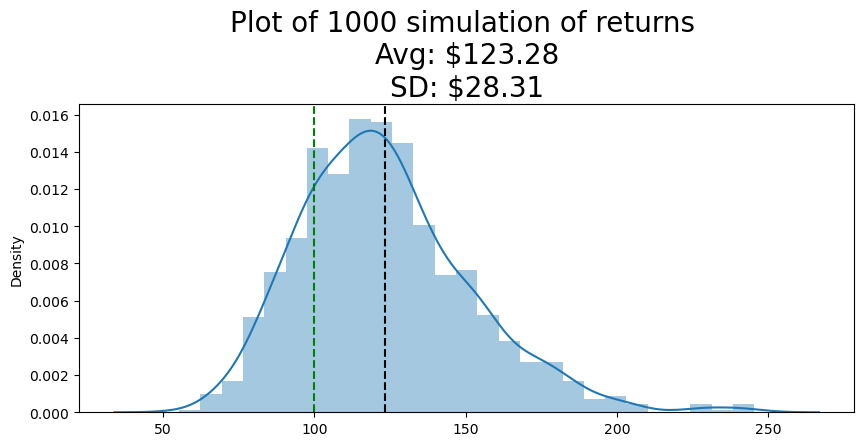

In [43]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Plot of 1000 simulation of returns \nAvg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

### Trying the model AR

In [100]:
#for thresh in [0, 10, 50]:
    #run_simulation(returns, prices, 100, (3,1,3), thresh, verbose=False)